In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

In [11]:
IMG_SIZE = 28
MIN_MARGIN = 10  # мінімальна відстань від краю
MIN_SIZE = 5
MAX_SIZE = 8
CLASSES = ['circle', 'square', 'triangle']

def generate_shape_image(shape: str) -> np.ndarray:
    img = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

    max_shape_size = 6  # зменшений розмір фігур
    size = random.randint(4, max_shape_size)
    angle = random.uniform(0, 360)

    margin = int(np.ceil(size * 1.5))  # запас для обертання
    center = (
        random.randint(margin, IMG_SIZE - margin),
        random.randint(margin, IMG_SIZE - margin)
    )

    if shape == 'circle':
        cv2.circle(img, center, size, 255, -1)

    elif shape == 'square':
        # створити квадрат навколо центру
        box = np.array([
            [-size, -size],
            [ size, -size],
            [ size,  size],
            [-size,  size]
        ], dtype=np.float32)
        # повернути його
        rot = cv2.getRotationMatrix2D((0, 0), angle, 1.0)
        box = np.dot(box, rot[:, :2].T)
        box += np.array(center)
        cv2.fillConvexPoly(img, box.astype(np.int32), 255)

    elif shape == 'triangle':
        pts = np.array([
            [0, -size],
            [-size, size],
            [size, size]
        ], dtype=np.float32)
        rot = cv2.getRotationMatrix2D((0, 0), angle, 1.0)
        pts = np.dot(pts, rot[:, :2].T)
        pts += np.array(center)
        cv2.fillConvexPoly(img, pts.astype(np.int32), 255)

    return img


In [12]:

def generate_dataset(num_samples_per_class=1000):
    X = []
    y = []

    for label, shape in enumerate(CLASSES):
        for _ in range(num_samples_per_class):
            img = generate_shape_image(shape)
            X.append(img)
            y.append(label)

    X = np.array(X).astype('float32') / 255.0  # Нормалізація
    X = X[..., np.newaxis]  # додати канал
    y = np.array(y)

    return X, y

# Генеруємо дані
X, y = generate_dataset()

from sklearn.utils import shuffle
X, y = shuffle(X, y)


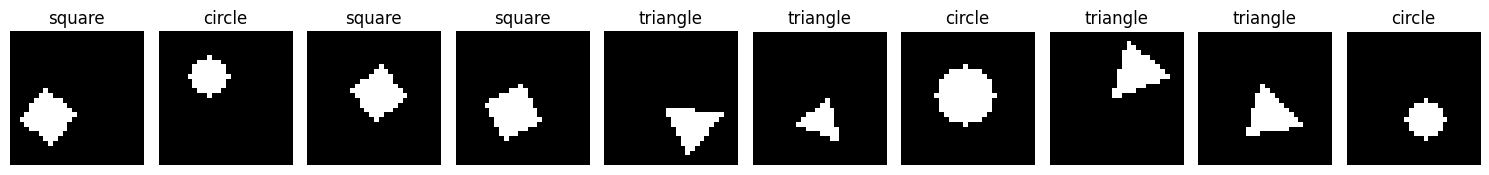

In [13]:
# Показати 10 випадкових зображень
indices = np.random.choice(len(X), 10, replace=False)
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i, idx in enumerate(indices):
    axs[i].imshow(X[idx].squeeze(), cmap='gray')
    axs[i].set_title(CLASSES[y[idx]])
    axs[i].axis('off')
plt.tight_layout()
plt.show()


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(CLASSES), activation='softmax')
])


c:\Users\yardz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4184 - loss: 1.0582 - val_accuracy: 0.5583 - val_loss: 0.8563
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6181 - loss: 0.8262 - val_accuracy: 0.6950 - val_loss: 0.6538
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7935 - loss: 0.5223 - val_accuracy: 0.9200 - val_loss: 0.2761
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9572 - loss: 0.2015 - val_accuracy: 0.9317 - val_loss: 0.2143
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9809 - loss: 0.1038 - val_accuracy: 0.9567 - val_loss: 0.1262
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9867 - loss: 0.0663 - val_accuracy: 0.9750 - val_loss: 0.0650
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9956 - loss: 0.0304 - val_accuracy: 0.9833 - val_loss: 0.0489
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0185 - val_accuracy: 0.9667 - val_loss:

In [17]:
# Оцінка моделі на всіх даних
loss, accuracy = model.evaluate(X, y, verbose=2)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

94/94 - 0s - 2ms/step - accuracy: 0.9977 - loss: 0.0124
Loss: 0.0124, Accuracy: 0.9977


In [18]:
history2 = model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)
loss, accuracy = model.evaluate(X, y, verbose=2)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9900 - val_loss: 0.0308
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9900 - val_loss: 0.0312
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.9917 - val_loss: 0.0308
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9900 - val_loss: 0.0244
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9917 - val_loss: 0.0257
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9900 - val_loss: 0.0223
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9933 - val_loss: 0.0214
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2938e-04 - val_accuracy: 0.9933 - val_l

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Кількість невірно класифікованих зображень: 4


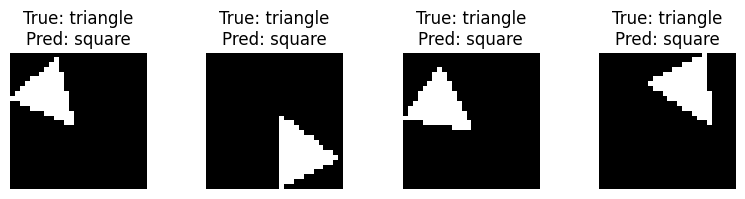

In [19]:
# Отримати передбачення моделі
y_pred = model.predict(X)
y_pred_labels = np.argmax(y_pred, axis=1)

# Індекси невірних передбачень
wrong_indices = np.where(y_pred_labels != y)[0]

print(f"Кількість невірно класифікованих зображень: {len(wrong_indices)}")

# Вивести всі невірно класифіковані зображення
if len(wrong_indices) > 0:
    n = len(wrong_indices)
    fig, axs = plt.subplots(1, n, figsize=(2*n, 2))
    if n == 1:
        axs = [axs]
    for i, idx in enumerate(wrong_indices):
        axs[i].imshow(X[idx].squeeze(), cmap='gray')
        axs[i].set_title(f"True: {CLASSES[y[idx]]}\nPred: {CLASSES[y_pred_labels[idx]]}")
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Модель правильно класифікує всі зображення.")

In [20]:
# Згенерувати новий датасет
X_new, y_new = generate_dataset(num_samples_per_class=300)

# Перемішати новий датасет
X_new, y_new = shuffle(X_new, y_new)

# Оцінити модель на новому датасеті
loss_new, accuracy_new = model.evaluate(X_new, y_new, verbose=2)
print(f"Loss on new dataset: {loss_new:.4f}, Accuracy on new dataset: {accuracy_new:.4f}")

29/29 - 0s - 3ms/step - accuracy: 0.9911 - loss: 0.0173
Loss on new dataset: 0.0173, Accuracy on new dataset: 0.9911
